In [1]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datapath = 'Data/cell_images/training_set/BW/'

In [3]:
import lib.dataloader
from Model.Predictor_Parallel import Predictor

/Users/HarveyYan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
BATCH_SIZE = 200
N_EMB = 3 # 3 channels for augmented images
DEVICES = ['/cpu:0']
digits_limits = 8

# defining the hyperparameters
HParams = ['arch', 'use_bn', 'use_lstm', 'nb_layers', 'filter_size', 'output_dim',
           'learning_rate', 'use_clr', 'use_momentum', 'length_obj_ratio']

arch = 1
use_bn = True
use_lstm = True
nb_layers = 4
filter_size = 3
output_dim = 16
learning_rate = 2e-4
use_clr = True
use_momentum = False
length_obj_ratio = 0.

hp = {}
for param in HParams:
    hp[param] = eval(param)
    
lib.dataloader.digits_limit = digits_limits
lib.dataloader.nb_channels = N_EMB

In [5]:
dataset = lib.dataloader.load_ocr_dataset()

dataset size 7497
training set 6748
test set 749


(34, 84, 3)


(-0.5, 83.5, 33.5, -0.5)

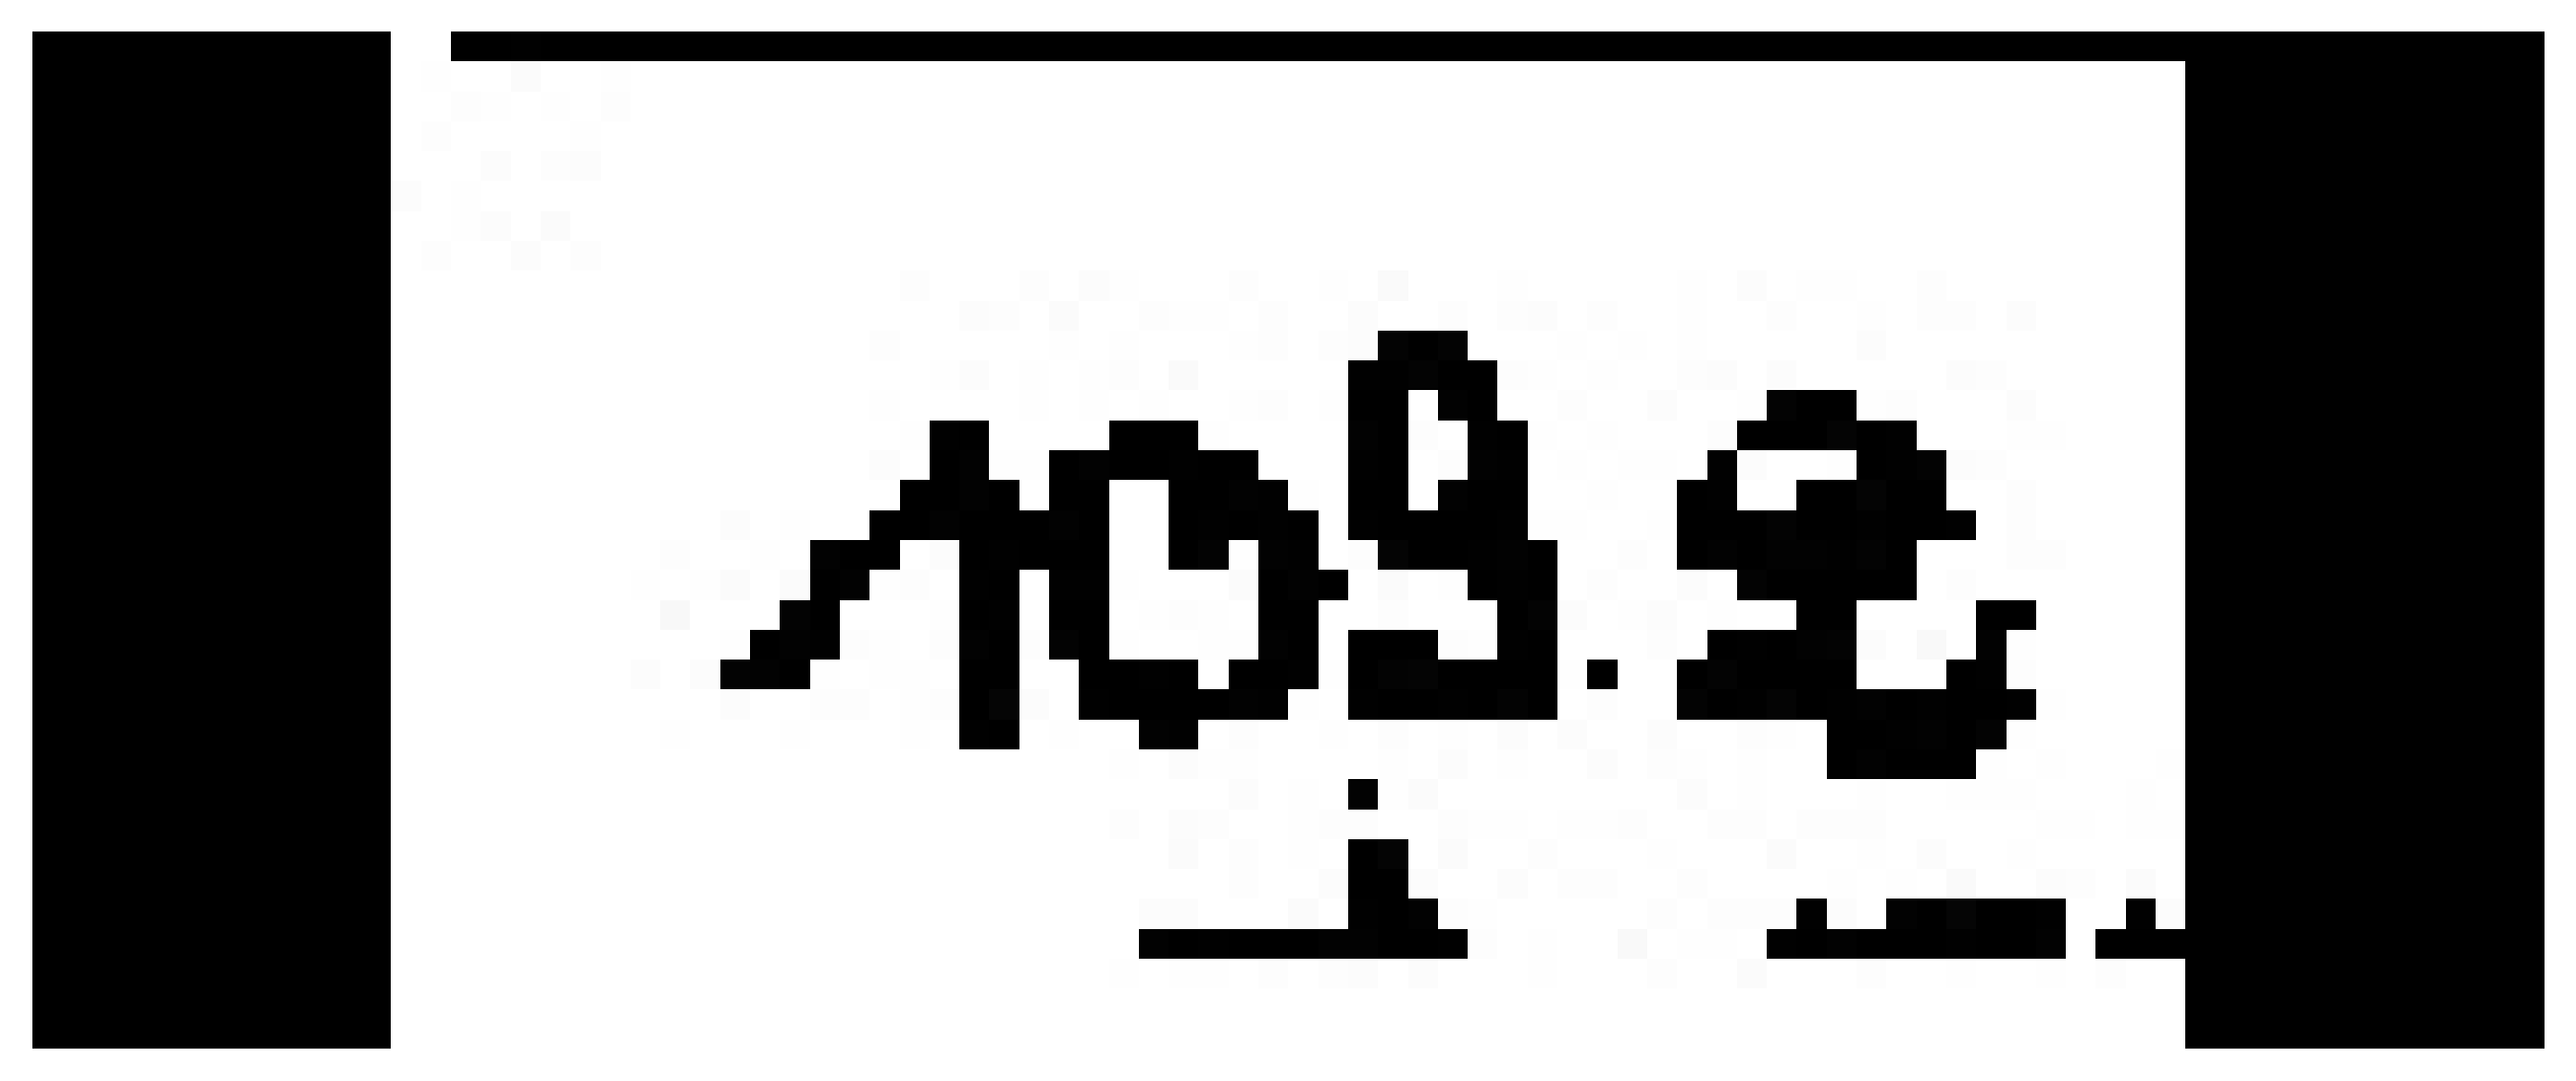

In [6]:
print(dataset['test_images'][0].shape)
plt.imshow(dataset['test_images'][0], cmap='gray')
plt.axis('off')

In [7]:
dataset['test_ids'][0]

'5508.jpg'

In [8]:
[lib.dataloader.all_allowed_characters[idx] for idx in dataset['test_targets'][0]]

['1', '0', '9', '.', '2', '!', '!', '!']

'!' is a dummy character we used to pad sequences to same length. Even though RNN is dynamic, for batch operation it's unrolled for a fixed/maximal steps

In [9]:
DEVICES

['/cpu:0']

In [10]:
N_CLASS = len(lib.dataloader.all_allowed_characters)
model = Predictor(lib.dataloader.max_size, N_EMB, N_CLASS, lib.dataloader.max_target_length, lib.dataloader.digits_limit, DEVICES, **hp)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
hidden units in the decoder 128, same as the encoder
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
hidden units in the decoder 128, same as the encoder
Predictor arch 1 Params:
	Classifier/pretrain_effect_zone/Shortcut/filters:0 (1,1,3,16)
	Classifier/pretrain_effect_zone/Shortcut/bias:0 (16)
	Classifier/pretrain_effect_zone/Conv1/filters:0 (3,3,3,16)
	Classifier/pret

In [11]:
chkp_path = 'output/20190616-154224-3-channels-corrected-nolength-4layers/checkpoints/-3877'

In [12]:
model.load(chkp_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from output/20190616-154224-3-channels-corrected-nolength-4layers/checkpoints/-3877


## Some model surgery 

In [13]:
import tensorflow as tf

Feature map tensor

In [14]:
resnet_output = model.g.get_tensor_by_name('Classifier_1/pretrain_effect_zone/Relu_1:0')

print('Feature map after resblock 7', resnet_output.get_shape().as_list())

Feature map after resblock 7 [None, 9, 21, 64]


Attention weights (probabilities) tensor

In [15]:
attention_tensor = model.inference_att_weights
print(attention_tensor.get_shape().as_list())

[None, None, None]


In [16]:
encoder_output = model.g.get_tensor_by_name('Classifier_1/Encoder/concat:0')
encoder_output.shape.as_list()

[None, None, 128]

In [17]:
logits_vector = model.g.get_tensor_by_name('Classifier_1/Decoder/transpose:0')
print(logits_vector.shape.as_list())

[None, None, 128]


#### Making a prediction for "109.2"

original shape in (height, width, channels): (34, 84, 3)


(-0.5, 83.5, 33.5, -0.5)

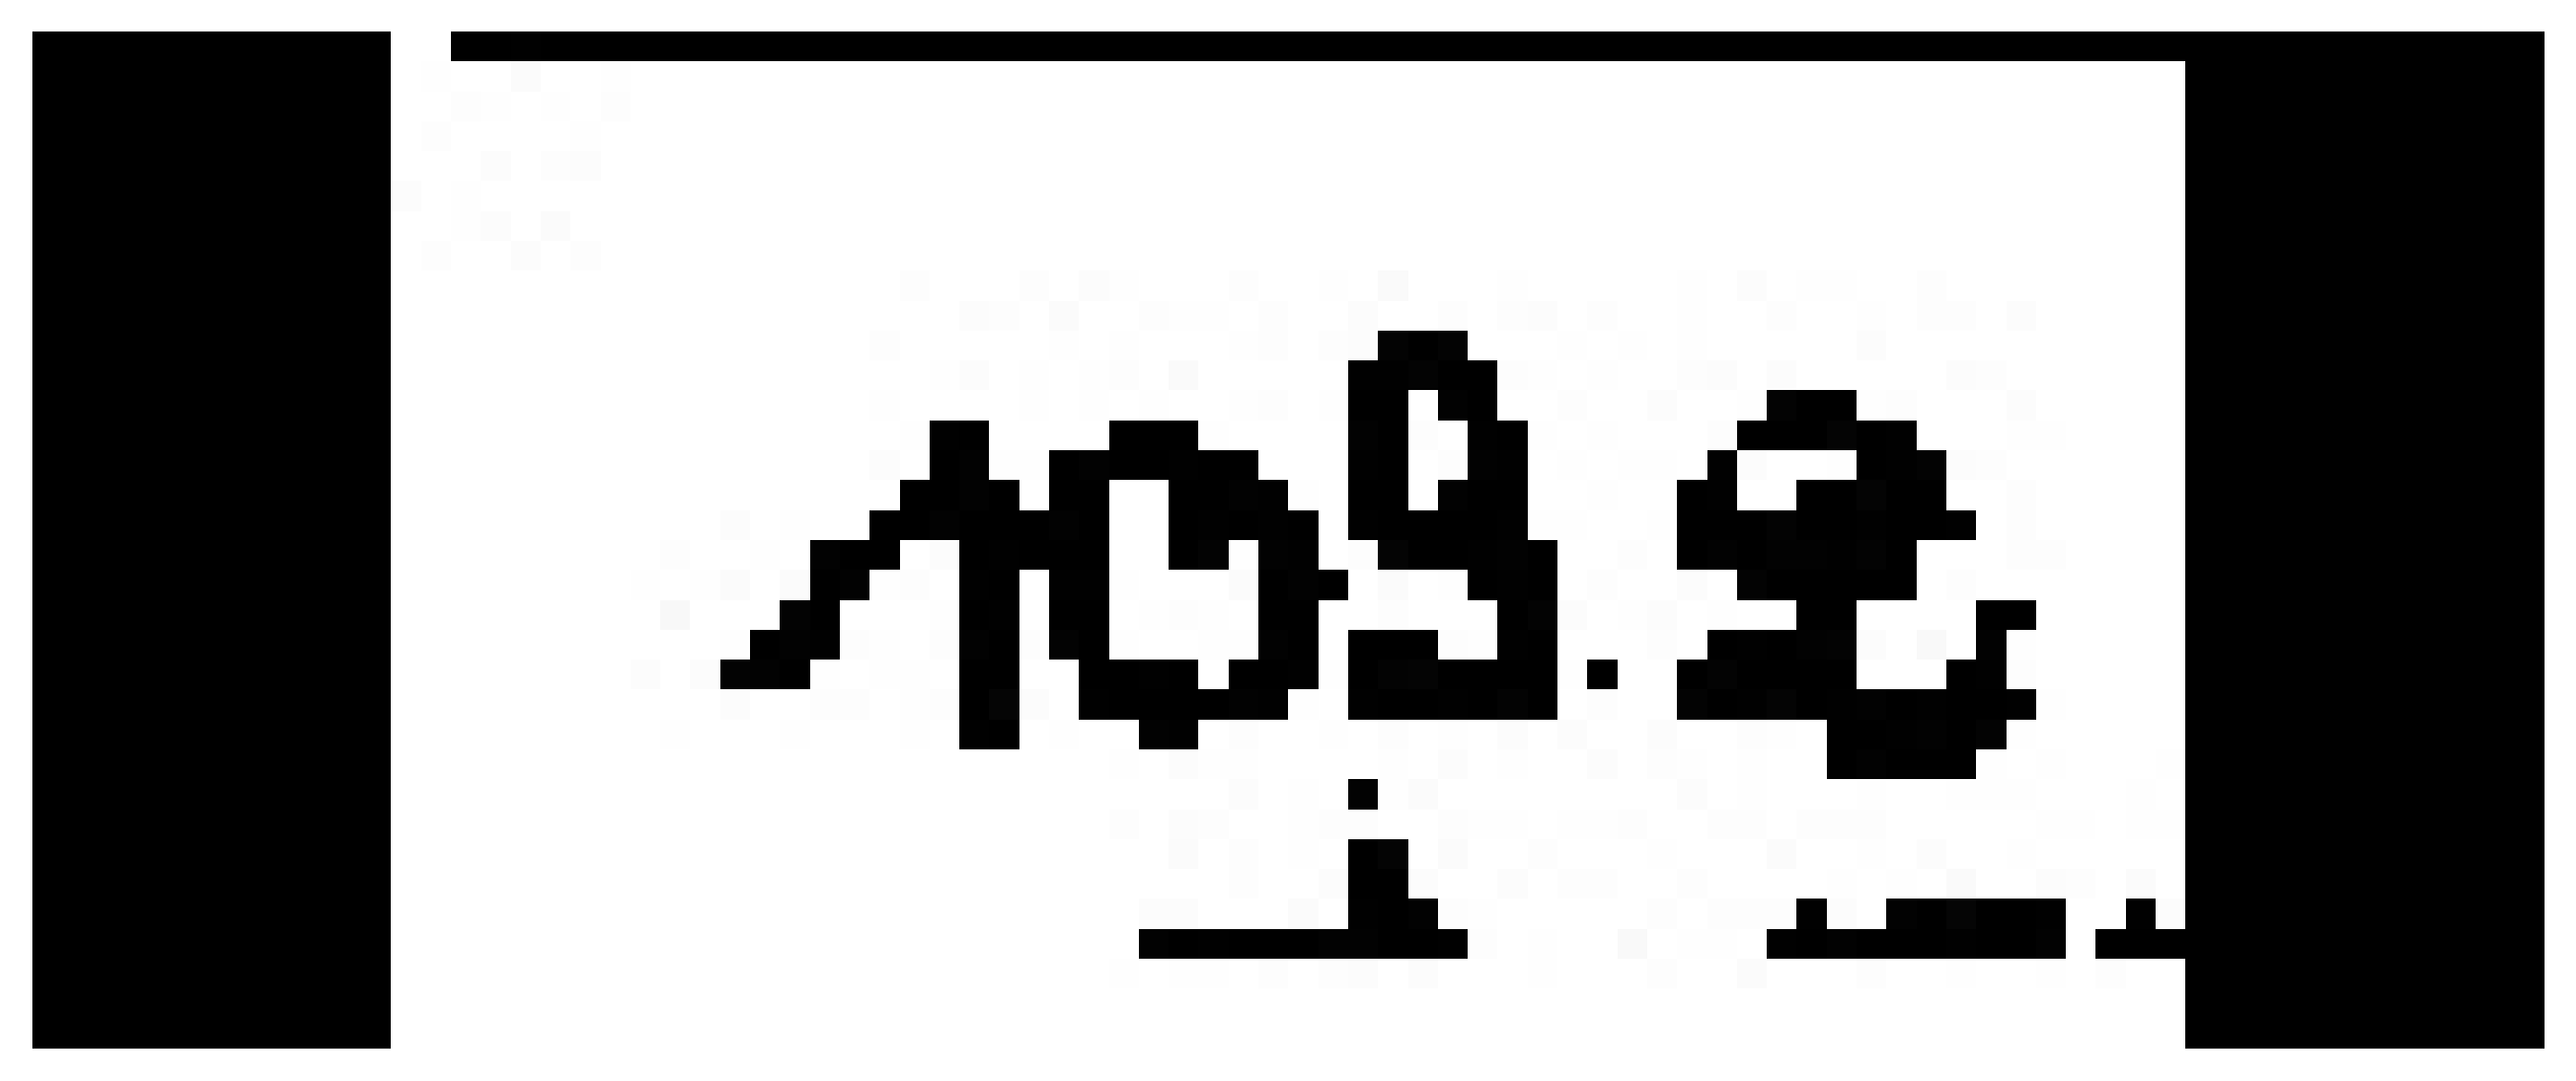

In [18]:
print('original shape in (height, width, channels):', dataset['test_images'][0].shape)
# image = cv2.resize(dataset['test_images'][1], (0,0), fx=1/2/2/2/2, fy=1/2/2/2/2)
# print(image.shape)
plt.imshow(dataset['test_images'][0], cmap='gray')
plt.axis('off')

In [19]:
import numpy as np
print('Preidction', [lib.dataloader.all_allowed_characters[idx] for idx in np.argmax(model.predict(dataset['test_images'][0][None, :, :, :]), axis=-1)[0]])
print('Ground truth', [lib.dataloader.all_allowed_characters[idx] for idx in dataset['test_targets'][0]])

Preidction ['1', '0', '9', '.', '2', '!', '!', '!']
Ground truth ['1', '0', '9', '.', '2', '!', '!', '!']


In [20]:
# obtaining feature maps and attention weights
final_fm, att_weights = model.sess.run([resnet_output, attention_tensor], {
    model.inference_input_ph: dataset['test_images'][0][None, :, :, :],
    model.is_training_ph: False
})

## Visualizing feature maps

In [21]:
f, axes = plt.subplots(8, 8, figsize=(80, 40))
for i in range(final_fm.shape[-1]):
    axes[i//8,i%8].imshow(final_fm[0, :, :, i], cmap='gray')
    axes[i//8,i%8].axis('off')
    axes[i//8,i%8].set_title('fearure: %d' % (i))
# f.subplots_adjust(hspace=-0.5, wspace=0.4)
f.tight_layout()
plt.show()

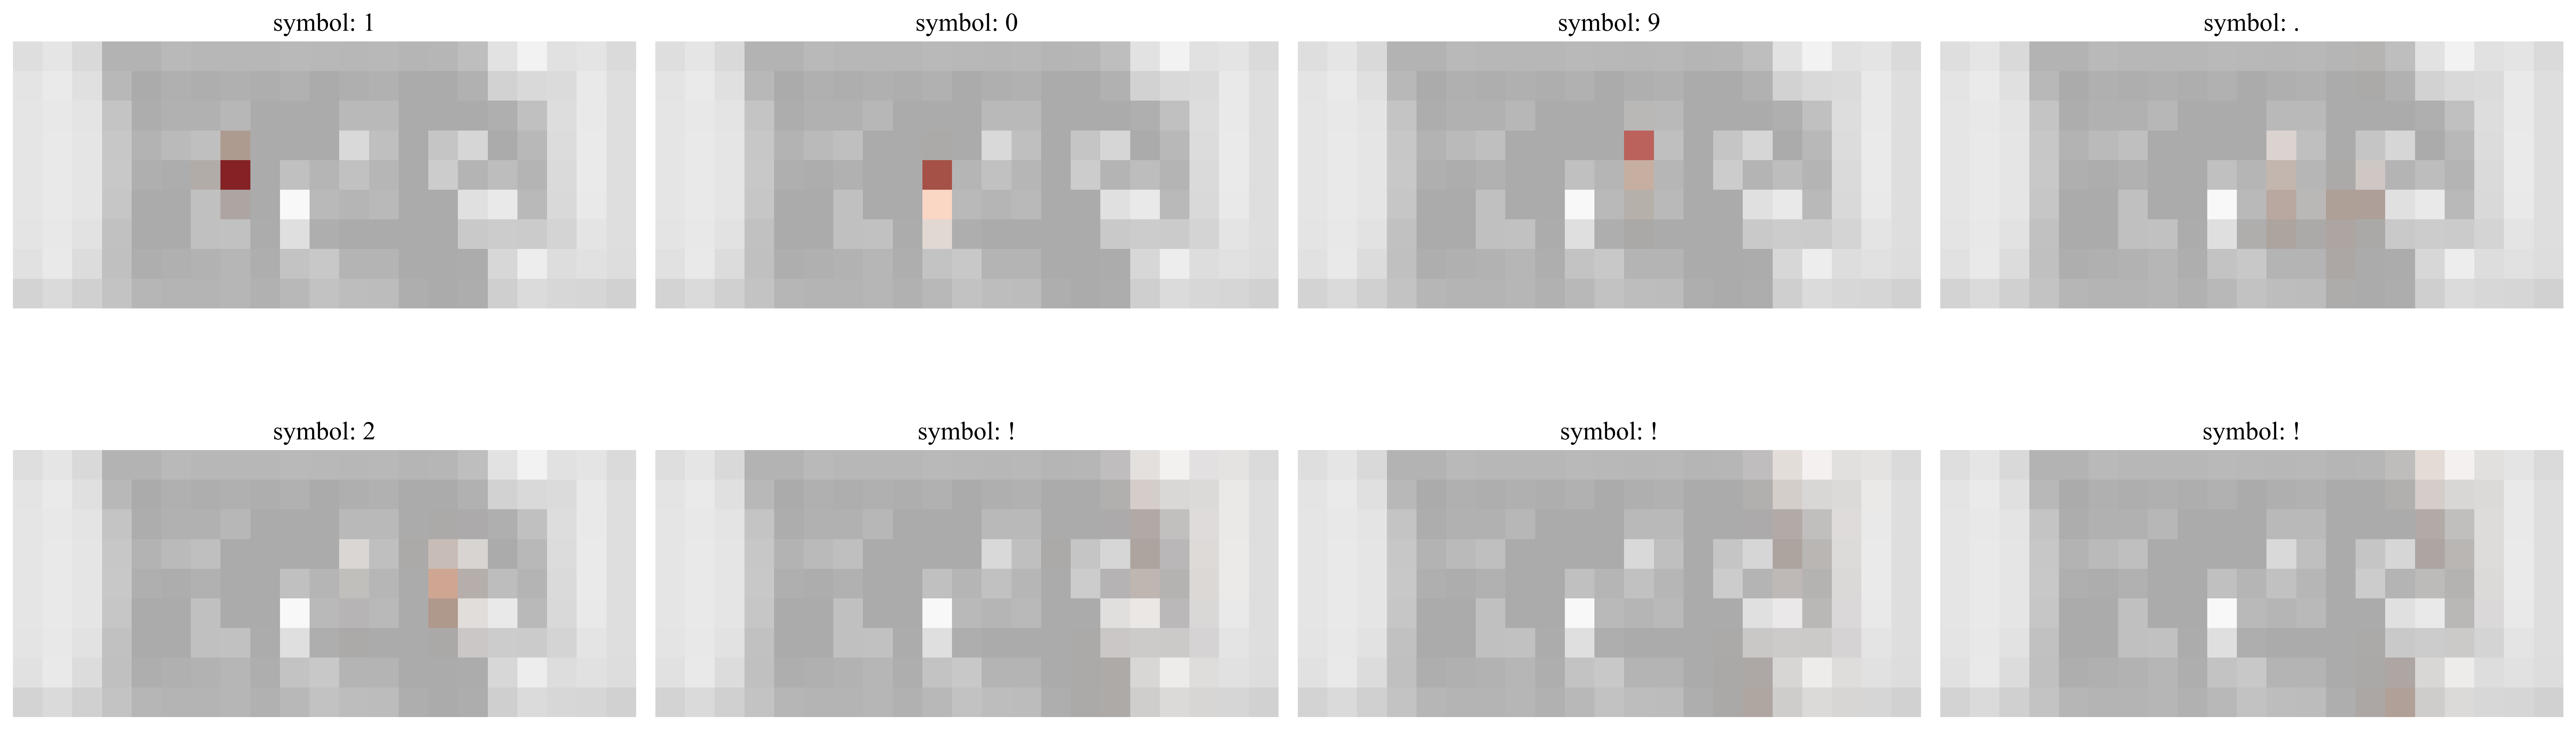

In [31]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

f, axes = plt.subplots(2, 4, figsize=(20,10))
for i in range(att_weights.shape[1]):
    axes[i//4,i%4].imshow(final_fm[0, :, :, 2], cmap='gray')
    axes[i//4,i%4].imshow(att_weights[0, i, :].reshape(21,9).T, cmap='RdBu_r', vmin=-1., vmax=1., alpha=0.7)
#     axes[i//4,i%4].imshow(att_weights[0, i, :].reshape(21,9).T, cmap='gray')
#     axes[i//4,i%4].contourf(x, y, Gauss.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap)
    axes[i//4,i%4].axis('off')
    axes[i//4,i%4].set_title('symbol: ' + lib.dataloader.all_allowed_characters[dataset['test_targets'][0][i]])
f.subplots_adjust(hspace=-0.5, wspace=0.4)
f.tight_layout()